In [1]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import shuffle
import pandas as pd
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('http_requests.csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
df = shuffle(df)
df['payload'] = df['payload'].fillna(0)
df['payload'] = df['payload'].apply(lambda x: str(x))
df.drop(columns=['index', 'method', 'url', 'protocol', 'userAgent', 'pragma', 'cacheControl', 'accept', 'acceptEncoding', 'acceptCharset', 'acceptLanguage', 'host', 'connection', 'contentLength', 'contentType', 'cookie'], inplace=True)

In [3]:
print(df.head())

                       payload label
204305    ntc=9758111869432578  norm
109508               precio=85  anom
172470                       0  norm
80055            modo=registro  anom
3709    B1=A%F1adir+al+carrito  anom


In [4]:
# Function to generate a 255 dim feature vector from 'payload'
# Return a list of length 255 with features of payloads mapped to it
# Each list index represents an ASCII character and value represents count
# q = [4, 5, 2, 6, 12,  ....]


def vectorize_payload(payload):
    vec_255 = [0]*255
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 1))
    vectorized = vectorizer.fit_transform([payload])
    mapped = list(zip(vectorizer.get_feature_names(), vectorized.sum(0).getA1()))
    for x in mapped:
        vec_255[ord(x[0])] = x[1]
    return vec_255


In [5]:
# conversion to 256 dimensional vector
vectors = np.array(df['payload'].apply(lambda x: vectorize_payload(x)))
vectors


array([list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 2, 1, 2, 3, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

In [7]:
# Function to generate frequency for 255 dim feature vectors
# Return a list of length 255 with feature frequencies
# Each list index represents an ASCII character and value represents its frequency
# q = [0.23, 0, 0, 0.03, 0.42,  ....] = 1


def calc_frequency(payloads_vectors):
    features_total = 0
    for feature in payloads_vectors:
        features_total += feature
    features_total *= 1.0
    payloads_vectors = [(x/features_total) for x in payloads_vectors]
    return np.array(payloads_vectors, dtype=np.float16)


results = [calc_frequency(x) for x in vectors]
features_frequency = np.vstack(results)
del results


In [8]:
# Function to generate mean vector for n payloads
# Assuming data set has traffic of n packets
# Return a list of length 255 with mean for every 255 features from payload vectors
# x' = [2.3, 3.1, 2.23, 7.5, 12.2,  ....]


def calc_mean(frequency_vectors):
    # TOTAL_PACKETS = len(vectors)
    # compiled = [0.0]*255
    # for x in frequency_vectors:
    #     compiled = list(map(sum, zip(compiled, x)))
    # return np.array([x/(TOTAL_PACKETS*1.0) for x in compiled], dtype=np.float16)
    return np.mean(frequency_vectors, axis=0)


features_mean = calc_mean(features_frequency)


In [9]:
# Function to generate sample covariance matrix n-1
# Assuming data set has traffic of n packets
# Return a covariance matrix for given frequency vectors


def calc_cov_mat():
    TOTAL_OBSERVATIONS = len(vectors)
    mean_shift = np.transpose(np.subtract(features_frequency, features_mean))    
    return np.cov(mean_shift), mean_shift


cov_mat, mean_shift = calc_cov_mat()


In [10]:
eig_val, eig_vec = np.linalg.eigh(cov_mat)

In [11]:
idx = np.argsort(eig_val)[::-1]
evecs = eig_vec[:,idx]
evals = eig_val[idx]
evecs = evecs[:, :2]

In [12]:
eig_pairs = [(np.abs(eig_val[x]), eig_vec[:,x]) for x in range(len(eig_val))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
for i in eig_pairs:
    print(i[0])


0.10455768859987909
0.010983678193024447
0.006383148583841978
0.0053391602005368475
0.004762418542702663
0.002984685365406982
0.002743298446938756
0.0026534564490624177
0.0022841380316715814
0.002115370617497742
0.0016624616382583007
0.0014812181354289468
0.0013743141260122297
0.001070271234651149
0.0010256431472531152
0.0009536531369257854
0.0008929515519591405
0.0008529953249946647
0.0008093897291523201
0.0007715308350351002
0.0006927332983509901
0.0006741828505504664
0.0006085870864172029
0.0005299914940684464
0.0005027194477562237
0.00045084637521579076
0.00037956849866167765
0.0003499295537917673
0.0002490447719663036
0.00022221487897273524
0.00021750400004594194
0.00015688526368854073
0.0001302693128470609
0.00012567617668126908
0.00012057970031200039
9.67873145353838e-05
5.139558656946528e-05
4.414525479325755e-05
4.35892510926719e-05
3.353897431985136e-05
1.1601350368353955e-05
9.873442116561316e-06
1.0098484929650829e-06
4.0703820824587124e-10
1.2876700521232306e-17
5.30166998

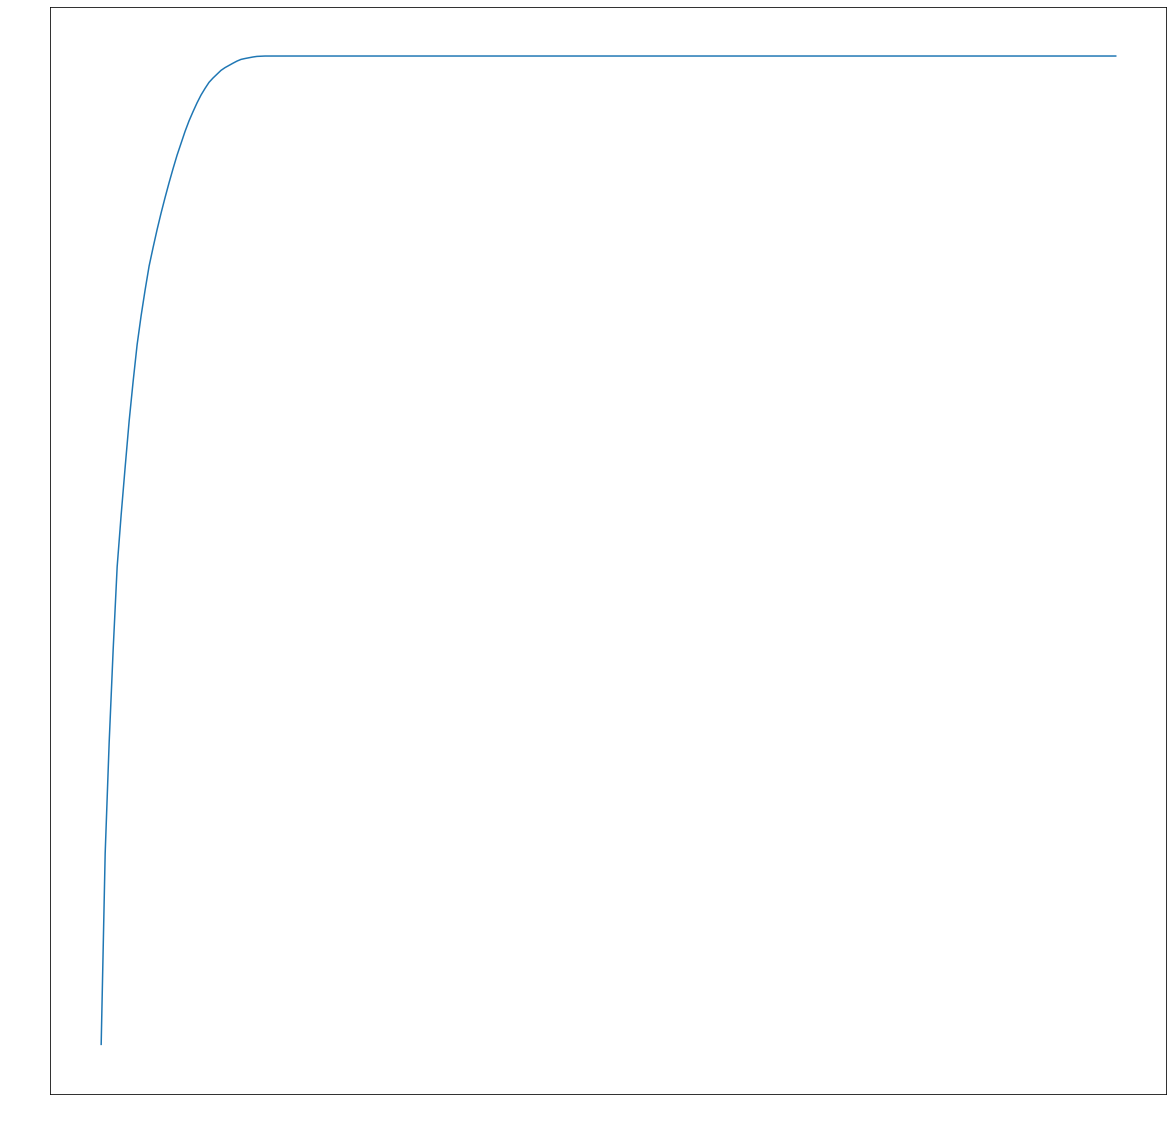

In [35]:
pca = PCA()
pca.fit_transform(features_frequency)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot()
ax.plot(np.cumsum(pca.explained_variance_ratio_))

ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance')

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()


In [ ]:
np.dot(evecs.T, mean_shift.T)


In [62]:
data_resc = np.dot(evecs.T, mean_shift).T

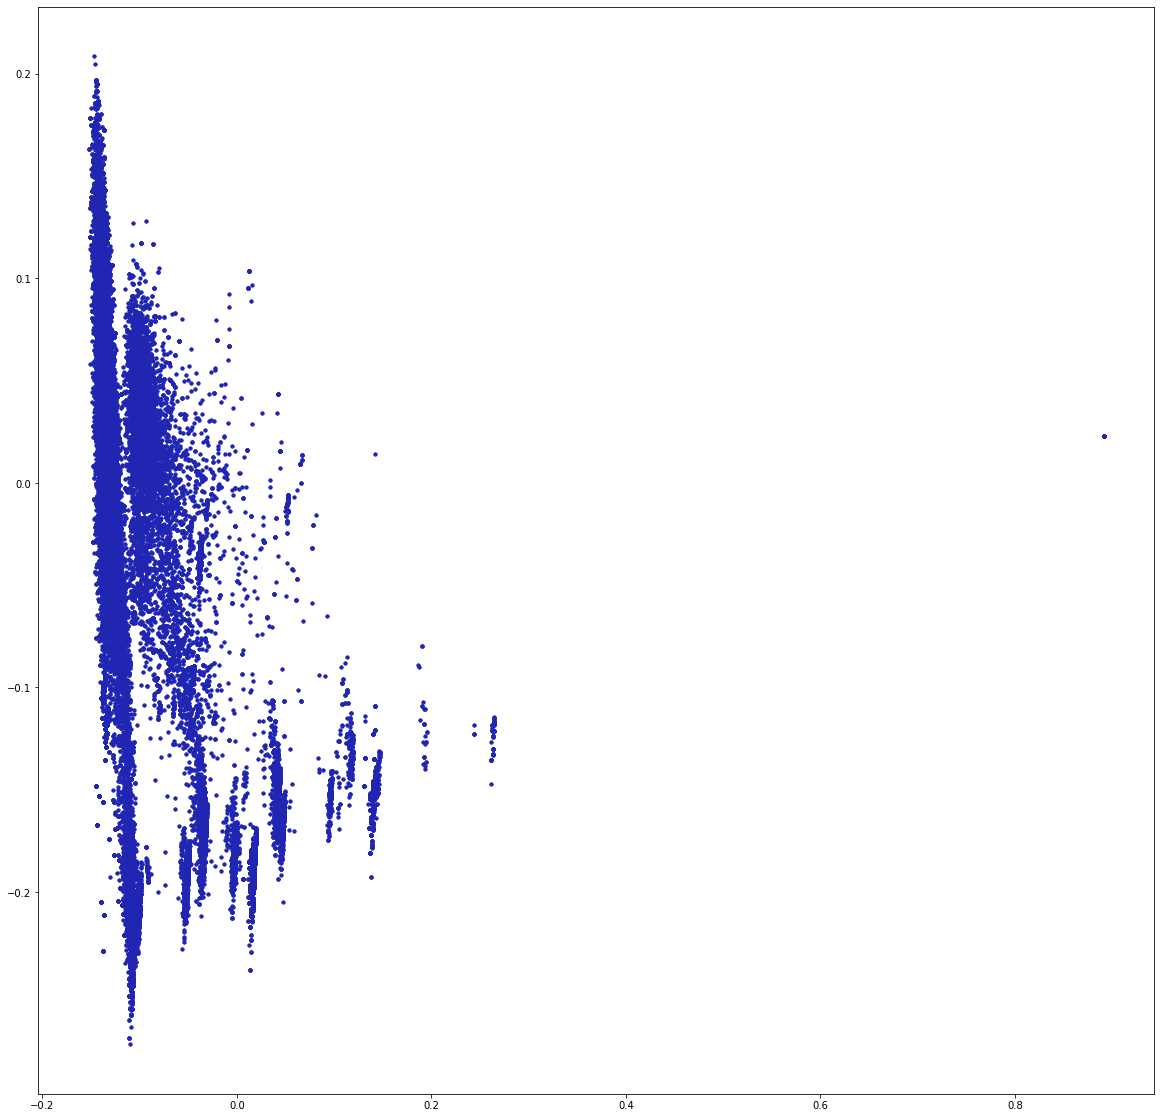

In [64]:
clr1 = '#2026B2'
fig2 = plt.figure(figsize=(20, 20))
ax1 = fig2.add_subplot(111)
ax1.plot(data_resc[:, 0], data_resc[:, 1], '.', mfc=clr1, mec=clr1)
plt.show()

In [ ]:
eig_val




In [13]:
def sum_cumulative_energy(pairs):
    THRESHOLD = 100e-6
    sum = 0
    for x in pairs:
        sum += x[0] if x[0] > THRESHOLD else 0
    return sum


cumulative_sum = sum_cumulative_energy(eig_pairs)


In [14]:
cumulative_sum


0.1611122045995596

In [35]:
def cumulative_constant(cumulative_sum, pairs):
    CUMULATIVE_THRESHOLD = 98
    current_sum, prev_sum, curr_cumsum = 0, -1, 100
    i = 0
    while (prev_sum != current_sum) and (curr_cumsum > CUMULATIVE_THRESHOLD):
        if i == len(pairs):
            break
        prev_sum = current_sum
        current_sum += pairs[i][0]
        curr_cumsum = 100 - (cumulative_sum / current_sum)
        print("Prev Sum: %f, Current Sum: %f, Curr cumsum: %f"%(prev_sum, current_sum, curr_cumsum))
        i += 1
    return i, curr_cumsum


num_of_PC, cumsum = cumulative_constant(cumulative_sum, eig_pairs)


Prev Sum: 0.000000, Current Sum: 0.104558, Curr cumsum: 98.459107
Prev Sum: 0.104558, Current Sum: 0.115541, Curr cumsum: 98.605589
Prev Sum: 0.115541, Current Sum: 0.121925, Curr cumsum: 98.678591
Prev Sum: 0.121925, Current Sum: 0.127264, Curr cumsum: 98.734028
Prev Sum: 0.127264, Current Sum: 0.132026, Curr cumsum: 98.779694
Prev Sum: 0.132026, Current Sum: 0.135011, Curr cumsum: 98.806672
Prev Sum: 0.135011, Current Sum: 0.137754, Curr cumsum: 98.830436
Prev Sum: 0.137754, Current Sum: 0.140408, Curr cumsum: 98.852539
Prev Sum: 0.140408, Current Sum: 0.142692, Curr cumsum: 98.870907
Prev Sum: 0.142692, Current Sum: 0.144807, Curr cumsum: 98.887401
Prev Sum: 0.144807, Current Sum: 0.146470, Curr cumsum: 98.900029
Prev Sum: 0.146470, Current Sum: 0.147951, Curr cumsum: 98.911041
Prev Sum: 0.147951, Current Sum: 0.149325, Curr cumsum: 98.921064
Prev Sum: 0.149325, Current Sum: 0.150395, Curr cumsum: 98.928742
Prev Sum: 0.150395, Current Sum: 0.151421, Curr cumsum: 98.935998
Prev Sum: 

In [37]:
num_of_PC, cumsum

(45, 99.00180876040987)

In [ ]:
for i in range(45):
    print(eig_pairs[i][0])
